In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import os
import copy
import random
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, recall_score, accuracy_score, precision_score, f1_score

In [22]:
train_p = 'seg_train/seg_train'
test_p = 'seg_test/seg_test'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/intel_places_ds'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, train_p),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


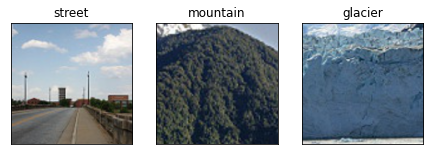

In [58]:
def show(images, labels):
  fig = plt.figure(figsize=(10,10))
  axes = []
  k = 0
  for i in range(3):
      axes.append(plt.subplot2grid((3, 4), (1, i)))
      inp = images[k]
      inp = inp.numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      axes[k].set_title(labels[k])
      axes[k].set_xticks([])
      axes[k].set_yticks([])
      plt.imshow(inp)
      k += 1
  plt.show()

X, y = next(iter(dataloaders['train']))
y = [class_names[x] for x in y[:3]]
show(X.to('cpu')[:3], y)

In [25]:
vgg_model = models.vgg16(pretrained=True)
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
for param in vgg_model.parameters():
  param.requires_grad = False

vgg_model.classifier[6] = nn.Linear(4096, 6)
vgg_model.classifier.add_module('7', nn.LogSoftmax(dim=1))
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters())

def train_model(model, criterion, optimizer, epochs=3):
  model.train()
  hist = []
  for epoch in range(epochs):
    last_model = copy.deepcopy(model)
    print("Epoch {} / {}: ".format(epoch + 1, epochs))

    train_loss = 0.0
    for i, (X, y) in enumerate(dataloaders['train']):
      X, y = X.to(device), y.to(device)

      optimizer.zero_grad()
      outputs = model(X)
      loss = criterion(outputs, y)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * X.size(0)
      
      if i % 50 == 0:
        print(i)
    
    train_loss = train_loss / len(image_datasets['train']) 
    print("Train Loss: ", train_loss)
    hist.append(train_loss)
  return model, hist

In [28]:
trained_model = train_model(vgg_model, loss, optimizer)

Epoch 1 / 3: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
50
100
150
200
Train Loss:  0.45252077857602335
Epoch 2 / 3: 
0
50
100
150
200
Train Loss:  0.38063581846150063
Epoch 3 / 3: 
0
50
100
150
200
Train Loss:  0.3907256121646989


In [34]:
def predict(model, dataloader):

  all_preds = torch.tensor([]).to(device)
  true_vals = torch.tensor([]).to(device)

  with torch.no_grad():
    model.eval()
    for (X, y) in dataloader:
      X, y = X.to(device), y.to(device)

      all_preds = torch.cat((all_preds, model(X)), 0)
      true_vals = torch.cat((true_vals, y), 0)
      
  return all_preds, true_vals

In [35]:
trained_vgg_model = trained_model[0].to(device)
outputs, labels = predict(trained_vgg_model, dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [36]:
_, outs = torch.max(outputs, dim=1)
print(classification_report(labels.cpu().numpy(), outs.cpu().numpy(), target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.94      0.92      0.93      2191
      forest       0.99      0.99      0.99      2271
     glacier       0.80      0.90      0.85      2404
    mountain       0.89      0.80      0.84      2512
         sea       0.98      0.94      0.96      2274
      street       0.92      0.94      0.93      2382

    accuracy                           0.91     14034
   macro avg       0.92      0.92      0.92     14034
weighted avg       0.92      0.91      0.91     14034



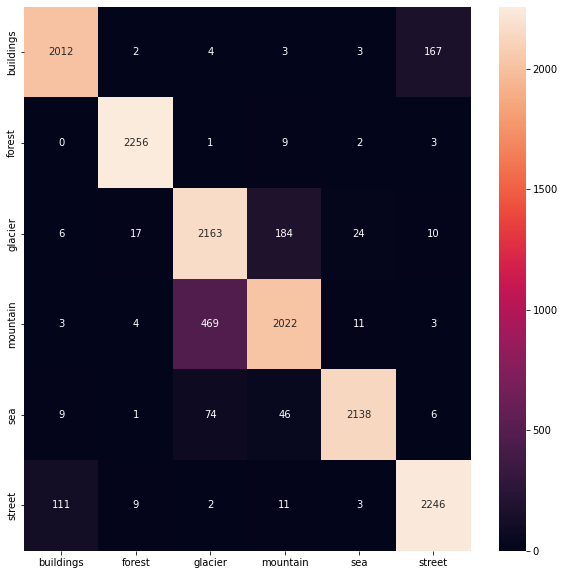

In [52]:
from seaborn import heatmap

confusion = confusion_matrix(labels.cpu().numpy(), outs.cpu().numpy())

fig = plt.figure(figsize=(10, 10))
heatmap(confusion,
        annot=True,
        fmt="d",
        xticklabels=list(class_names),
        yticklabels=list(class_names))

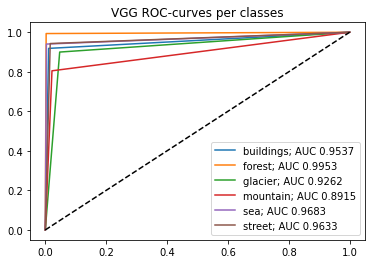

In [39]:
labels_plot = [(labels.cpu().numpy() == i).astype(float) for i in range(6)]
outs_plot = [(outs.cpu().numpy() == i).astype(float) for i in range(6)]
fpr_tpr = [roc_curve(labels_plot[i], outs_plot[i]) for i in range(6)]
roc_auc = [auc(fpr_tpr[i][0], fpr_tpr[i][1]) for i in range(6)]
plt.title('VGG ROC-curves per classes')

for i in range(6):
  plt.plot(fpr_tpr[i][0], fpr_tpr[i][1], label = (class_names[i] + "; AUC " + "%.4f" % (roc_auc[i])))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color = "black")
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


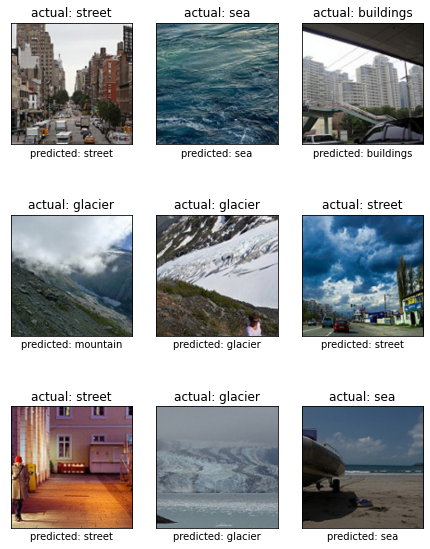

In [56]:
def show_pred(images, labels, predicts):
  fig = plt.figure(figsize=(10,10))
  axes = []
  k = 0
  for i in range(3):
    for j in range(3):
      axes.append(plt.subplot2grid((3, 4), (i, j)))
      inp = images[k]
      inp = inp.numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      axes[k].set_title('actual: {}'.format(labels[k]))
      axes[k].set_xlabel('predicted: {}'.format(predicts[k]))
      axes[k].set_xticks([])
      axes[k].set_yticks([])
      plt.imshow(inp)
      k += 1
  plt.show()

X, y = next(iter(dataloaders['test']))
X = X.to(device)
probas = trained_model[0](X)
_, preds = torch.max(probas, dim=1)
y = [class_names[x] for x in y[:9]]
preds = [class_names[x] for x in preds[:9]]
show_pred(X.to('cpu')[:9], y, preds)